In [442]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

## Data

In [306]:
data = pd.read_csv("sales_train.csv")
test = pd.read_csv("test.csv")
data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Select one ID (product + shop)

In [307]:
data = data[(data['shop_id']==25)&(data['item_id']==20949)]

In [308]:
data.shape[0]

800

### Prepare Data

In [309]:
data.dtypes

date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object

In [310]:
data.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [311]:
data = data.drop(columns = ['date_block_num', 'shop_id', 'item_id', 'item_price'])
data.head()

,date,item_cnt_day
362755,24.04.2013,1.0
362756,25.04.2013,1.0
362757,26.04.2013,3.0
459218,31.05.2013,16.0
459219,30.05.2013,21.0


### Parse Dates

In [312]:
data['day'] = data['date'].str[:2]
data['month'] = data['date'].str[3:5]
data['year'] = data['date'].str[-4:]
data.head()

,date,item_cnt_day,day,month,year
362755,24.04.2013,1.0,24,04,2013
362756,25.04.2013,1.0,25,04,2013
362757,26.04.2013,3.0,26,04,2013
459218,31.05.2013,16.0,31,05,2013
459219,30.05.2013,21.0,30,05,2013


In [313]:
data['ds'] = pd.DatetimeIndex(data['year'] + '-' + data['month'] + '-' + data['day'])

In [314]:
data = data.drop(columns=['date','day','month','year'])
data.head()

,item_cnt_day,ds
362755,1.0,2013-04-24
362756,1.0,2013-04-25
362757,3.0,2013-04-26
459218,16.0,2013-05-31
459219,21.0,2013-05-30


In [315]:
data = data.reset_index(drop = True)

In [316]:
data.shape[0], len(data['ds'].unique())

(800, 800)

In [317]:
data = data.sort_values('ds').set_index('ds')
series = data['item_cnt_day']
series[series <= 0] = 0.1
series[series > 150] = 150

In [318]:
idx = pd.date_range('2013-04-24', '2015-10-31')
s = series
#s.index = pd.DatetimeIndex(s.index)
s = s.reindex(idx)# fill_value=0)

In [319]:
s.interpolate(method='linear', inplace=True)

In [320]:
s

2013-04-24     1.0
2013-04-25     1.0
2013-04-26     3.0
2013-04-27     2.6
2013-04-28     2.2
              ... 
2015-10-27     6.0
2015-10-28    11.0
2015-10-29    19.0
2015-10-30    18.0
2015-10-31    24.0
Freq: D, Name: item_cnt_day, Length: 921, dtype: float64

## Exploration

In [321]:
s.describe()

count    921.000000
mean      16.397394
std       13.880478
min        1.000000
25%        8.000000
50%       14.000000
75%       21.000000
max      150.000000
Name: item_cnt_day, dtype: float64

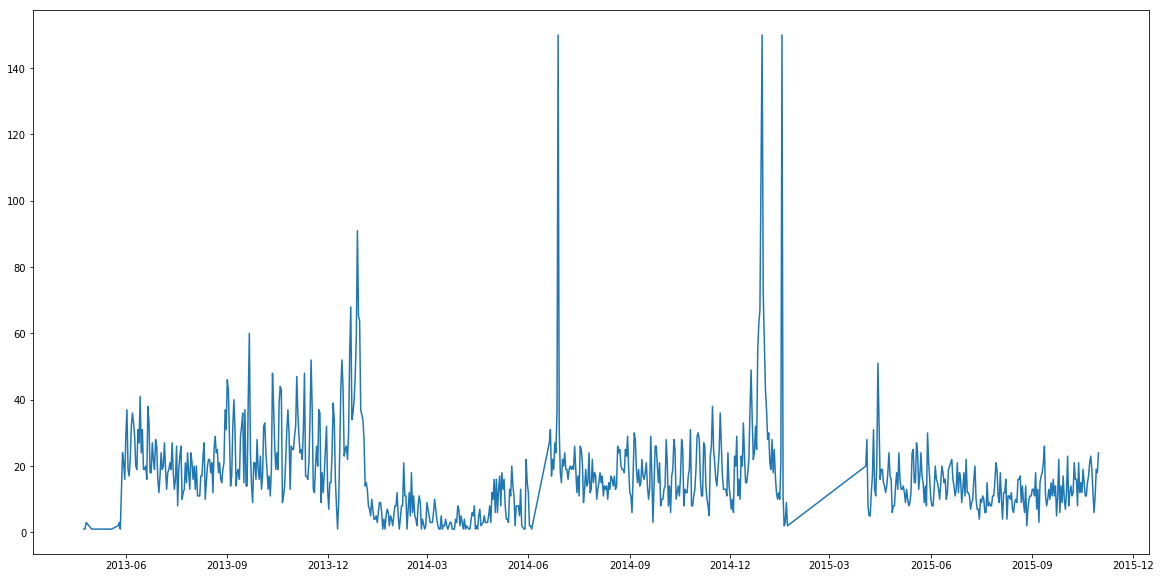

In [322]:
plt.figure(figsize = (20,10))
plt.plot(s,'-')

### Normal Distribution - log tranformation

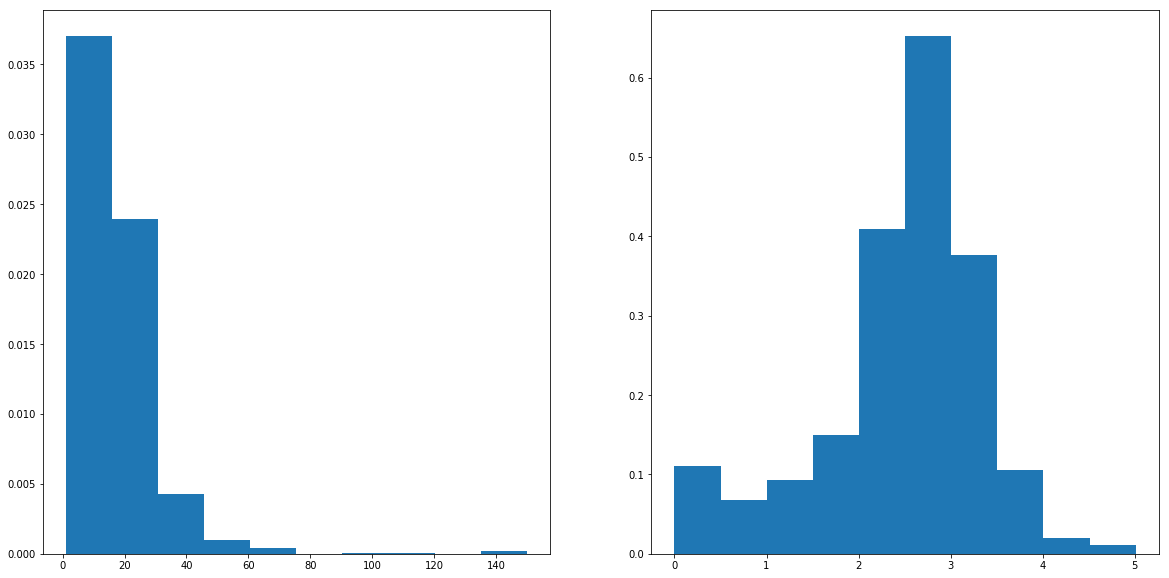

In [323]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.hist(s, bins=10, density=True)
plt.subplot(1,2,2)
plt.hist(np.log(s), bins=10, density=True)
plt.show()

In [324]:
s = np.log(s)

### Stationarity

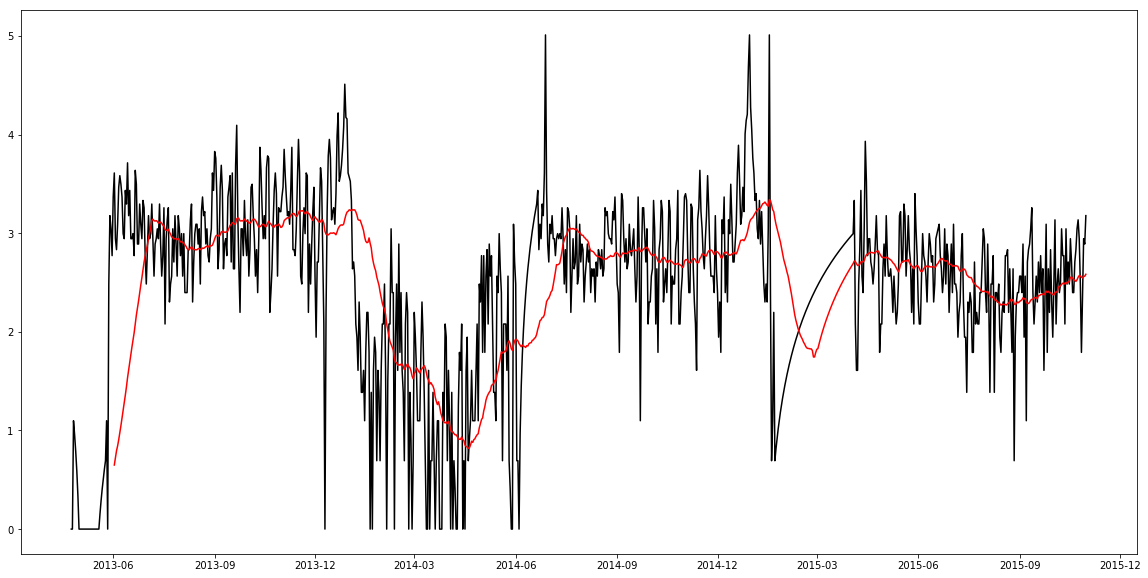

In [325]:
rolmean = s.rolling(40).mean()
rolstd  = s.rolling(40).std()

plt.figure(figsize = (20, 10))
plt.plot(s,'k-', label='stock closing price')
plt.plot(rolmean, 'r-', label='rolling mean')

In [326]:
adf = adfuller(s, autolag = 'AIC')
pval = adf[1]
pval #pval<0.05 -> stationary

1.6647150182919383e-05

## Model

### Train Test Split

In [327]:
test_size = 0.2
y_train, y_test = s[:int(len(s)*(1-test_size))], s[int(len(s)*(1-test_size)):]

In [328]:
s.shape[0], y_train.shape[0], y_test.shape[0]

(921, 736, 185)

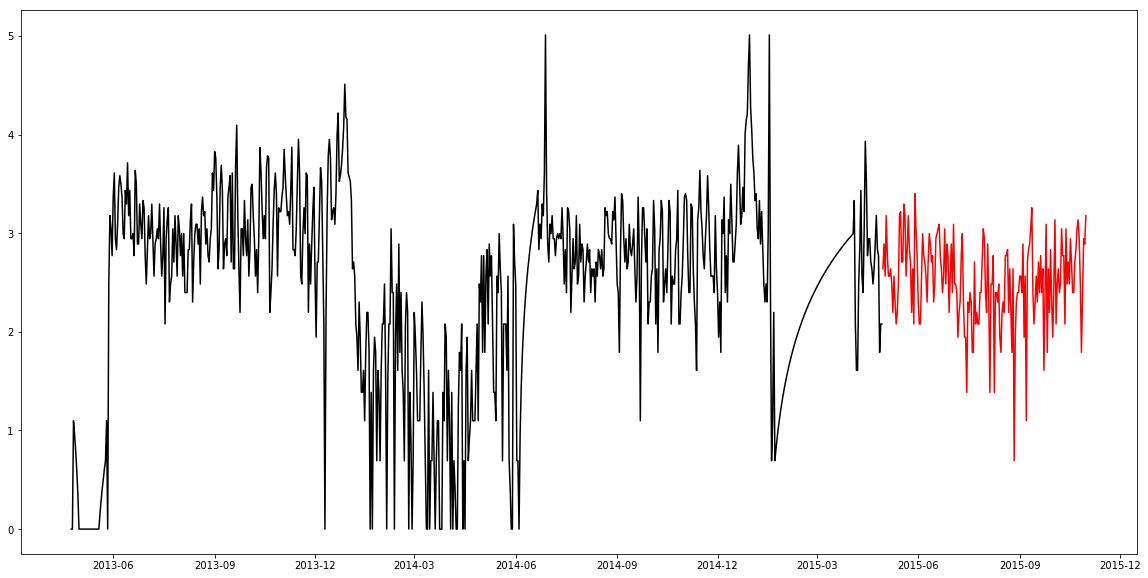

In [329]:
plt.figure(figsize = (20,10))
plt.plot(y_train,'k')
plt.plot(y_test,'r')

### SES

In [330]:
model = SimpleExpSmoothing(y_train)
#model._index = pd.to_datetime(y_train.index)

model = model.fit()
pred = model.forecast(int(len(s)*(1-test_size)))
pred = pd.Series(pred, index=y_test.index)

C:\Users\Matteo.Belloni\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


In [331]:
pred

2015-04-30    2.155058
2015-05-01    2.155058
2015-05-02    2.155058
2015-05-03    2.155058
2015-05-04    2.155058
                ...   
2015-10-27    2.155058
2015-10-28    2.155058
2015-10-29    2.155058
2015-10-30    2.155058
2015-10-31    2.155058
Freq: D, Length: 185, dtype: float64

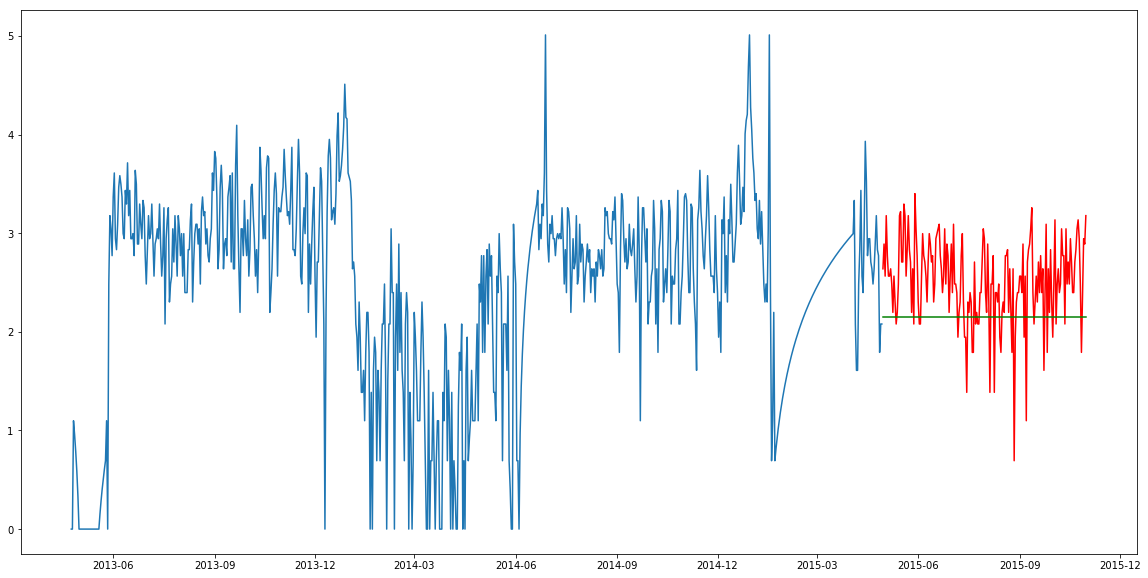

In [332]:
plt.figure(figsize = (20,10))
plt.plot(y_train)
plt.plot(y_test, 'r')
plt.plot(pred,'g')

In [333]:
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

7.040429027414458

### ETS

In [335]:
model = ExponentialSmoothing(y_train, seasonal_periods=12)
#model._index = pd.to_datetime(y_train.index)

model = model.fit()
pred = model.forecast(int(len(s)*(1-test_size)))
pred = pd.Series(pred, index=y_test.index)

C:\Users\Matteo.Belloni\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


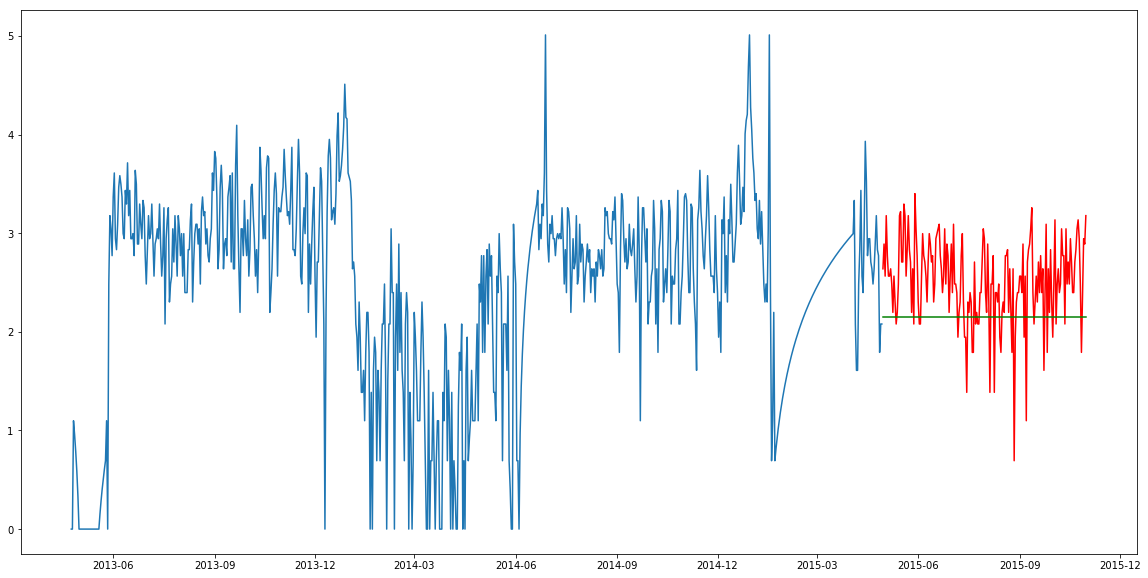

In [336]:
plt.figure(figsize = (20,10))
plt.plot(y_train)
plt.plot(y_test, 'r')
plt.plot(pred,'g')

In [337]:
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

7.040429027414458

### ARIMA

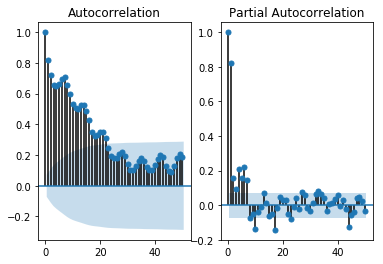

In [359]:
fig, ax = plt.subplots(1,2)
plot_acf(y_train, lags=50, ax=ax[0]);
plot_pacf(y_train, lags=50, ax=ax[1]); #k=2 cut -> p = 2

In [422]:
model = ARIMA(y_train, order=(2, 0, 0))  
model = model.fit()  
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           item_cnt_day   No. Observations:                  736
Model:                     ARMA(2, 0)   Log Likelihood                -619.129
Method:                       css-mle   S.D. of innovations              0.561
Date:                Sun, 02 May 2021   AIC                           1246.258
Time:                        17:46:17   BIC                           1264.662
Sample:                    04-24-2013   HQIC                          1253.356
                         - 04-29-2015                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.4315      0.142     17.174      0.000       2.154       2.709
ar.L1.item_cnt_day     0.6931      0.036     19.072      0.000       0.622       0.764
ar.L2.item_cnt_day     0.1622      0.036      4.445      0.000       0.091       0.234
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1391           +0.0000j            1.1391            0.0000
AR.2           -5.4122           +0.0000j            5.4122            0.5000
-----------------------------------------------------------------------------
"""

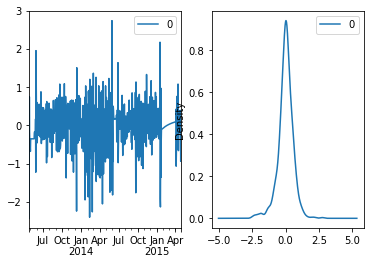

In [423]:
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(ax=ax[0])
residuals.plot(kind='kde', ax=ax[1]);

In [424]:
pred = model.forecast(int(len(s)*(1-test_size)))
pred = pd.Series(pred[0][:len(y_test)], index=y_test.index)

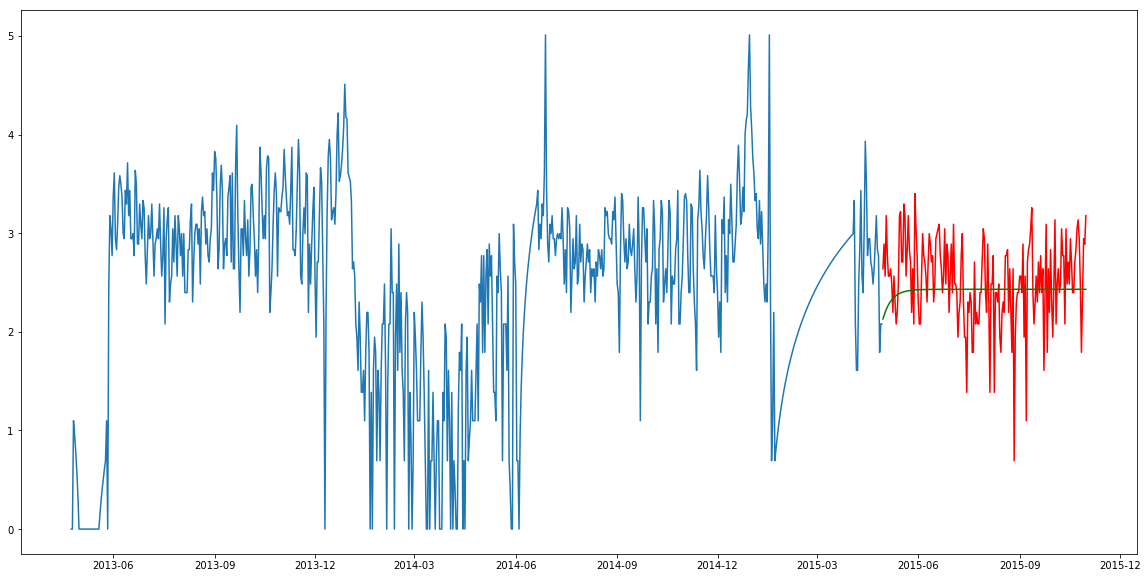

In [425]:
plt.figure(figsize = (20,10))
plt.plot(y_train)
plt.plot(y_test, 'r')
plt.plot(pred,'g')

In [426]:
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

5.667707334723411

In [438]:
model = sm.tsa.statespace.SARIMAX(y_train, order=(2, 0, 0), seasonal_order=(2,1,1,12))  
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         item_cnt_day   No. Observations:                  736
Model:             SARIMAX(2, 0, 0)x(2, 1, [1], 12)   Log Likelihood                -629.905
Date:                              Sun, 02 May 2021   AIC                           1271.810
Time:                                      17:50:35   BIC                           1299.319
Sample:                                  04-24-2013   HQIC                          1282.427
                                       - 04-29-2015                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6970      0.026     27.155      0.000       0.647       0.747
ar.L2          0.1893      0.026      7.174      0.000       0.138       0.241
ar.S.L12      -0.0769      0.040     -1.901      0.057      -0.156       0.002
ar.S.L24      -0.1277      0.039     -3.297      0.001      -0.204      -0.052
ma.S.L12      -0.9837      0.045    -21.893      0.000      -1.072      -0.896
sigma2         0.3136      0.014     21.784      0.000       0.285       0.342
===================================================================================
Ljung-Box (Q):                      241.18   Jarque-Bera (JB):               417.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.52
Prob(H) (two-sided):                  0.86   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [439]:
pred = model.forecast(int(len(s)*(1-test_size)))
pred = pred[:len(y_test)]

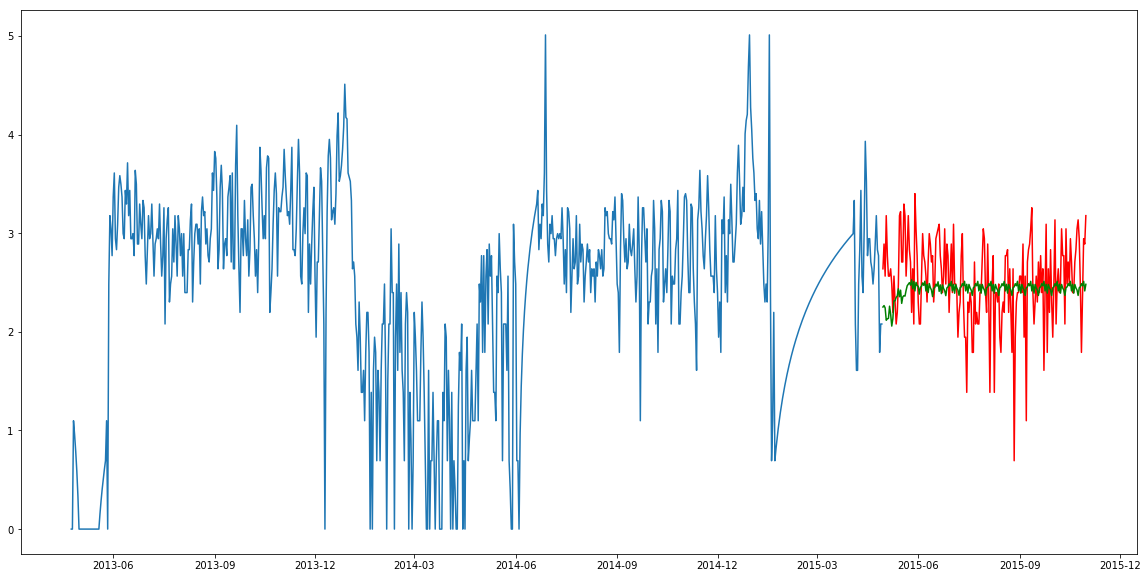

In [440]:
plt.figure(figsize = (20,10))
plt.plot(y_train)
plt.plot(y_test, 'r')
plt.plot(pred,'g')

In [441]:
np.sqrt(mean_squared_error(np.exp(y_test), np.exp(pred)))

5.630303871524074